# LSTM Autoencoders with Encodec

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import IPython
import time
import random
import torch
import torchaudio
import librosa
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

import sys
sys.path.append("..")
from dataset_generation.randomDataset import RandomDataset
from utils.numpyDataset import NumpyDataset

from torch import nn
from torch.nn import functional as F

/home/amosyou/.conda/envs/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# LSTM autoencoder
# credit: https://github.com/hellojinwoo/TorchCoder/blob/master/autoencoders/rae.py
class Encoder(nn.Module):
    def __init__(self, seq_len, no_features, embedding_size):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features    # The number of expected features(= dimension size) in the input x
        self.embedding_size = embedding_size   # the number of features in the embedded points of the inputs' number of features
        self.LSTM1 = nn.LSTM(
            input_size = no_features,
            hidden_size = self.embedding_size,
            num_layers = 1,
            batch_first=True
        )
        
    def forward(self, x):
        # Inputs: input, (h_0, c_0). -> If (h_0, c_0) is not provided, both h_0 and c_0 default to zero.
        # Outputs: output, (h_n, c_n)
        _, (hidden_state, cell_state) = self.LSTM1(x)  
        last_lstm_layer_hidden_state = hidden_state[-1,:,:]
        return last_lstm_layer_hidden_state
    
    
# (2) Decoder
class Decoder(nn.Module):
    def __init__(self, seq_len, embedding_size, output_size):
        super().__init__()

        self.seq_len = seq_len
        self.embedding_size = embedding_size
        self.output_size = output_size
        self.LSTM1 = nn.LSTM(
            input_size = self.embedding_size,
            hidden_size = 2 * self.embedding_size,
            num_layers = 1,
            batch_first = True
        )
        
        self.fc = nn.Linear(2 * self.embedding_size, self.output_size)
        
    def forward(self, x):
        # input is a embedding_dim x 1 vector
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, (hidden_state, cell_state) = self.LSTM1(x)
        x = x.reshape((-1, self.seq_len, 2 * self.embedding_size))
        out = self.fc(x)
        return out
    
    
# (3) Autoencoder : putting the encoder and decoder together
class LSTM_AE(nn.Module):
    def __init__(self, seq_len, no_features, embedding_dim):
        super().__init__()
        
        self.seq_len = seq_len
        self.no_features = no_features
        self.embedding_dim = embedding_dim

        self.encoder = Encoder(self.seq_len, self.no_features, self.embedding_dim)
        self.decoder = Decoder(self.seq_len, self.embedding_dim, self.no_features)
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [3]:
# load data
X, y = np.load('../dataset_generation/trainX.npy'), np.load('../dataset_generation/trainY.npy')
tensor_X, tensor_y = torch.Tensor(X), torch.Tensor(y)
dataset = TensorDataset(tensor_X, tensor_y)

In [4]:
dataset = NumpyDataset('../dataset_generation/trainX.npy', '../dataset_generation/trainY.npy')
train_data, val_data = random_split(dataset=dataset, lengths=[0.7, 0.3])
train_dl, val_dl = DataLoader(train_data, batch_size=64), DataLoader(val_data, batch_size=64)

In [4]:
for i in range(3):
    X_val, y_val = train_data[i]
    print(X_val)
    print(y_val)

[[0.6669922  0.94433594 0.6826172  ... 0.3642578  0.45214844 0.10058594]
 [0.12890625 0.14355469 0.50390625 ... 0.5283203  0.1953125  0.6308594 ]
 [0.5917969  0.16503906 0.16503906 ... 0.25683594 0.6113281  0.41601562]
 ...
 [0.38085938 0.95703125 0.68066406 ... 0.45996094 0.7763672  0.92871094]
 [0.90722656 0.8808594  0.24902344 ... 0.6074219  0.41015625 0.41210938]
 [0.40527344 0.8730469  0.42578125 ... 0.46484375 0.4501953  0.78027344]]
4
[[0.06054688 0.10351562 0.3984375  ... 0.8144531  0.8828125  0.41992188]
 [0.4140625  0.89160156 0.53125    ... 0.3544922  0.9199219  0.90625   ]
 [0.5878906  0.9589844  0.7675781  ... 0.6376953  0.9140625  0.859375  ]
 ...
 [0.6464844  0.828125   0.828125   ... 0.765625   0.6777344  0.7783203 ]
 [0.69628906 0.9355469  0.69628906 ... 0.4658203  0.8847656  0.7578125 ]
 [0.90625    0.71484375 0.41503906 ... 0.4501953  0.71484375 0.9296875 ]]
2
[[0.06054688 0.06054688 0.06054688 ... 0.86035156 0.9863281  0.9199219 ]
 [0.89160156 0.4140625  0.4140625  

In [5]:
train_data[0][0].shape

(16, 375)

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
loss = torch.nn.MSELoss()

seq_len = train_data[0][0].shape[1]
no_features = train_data[0][0].shape[0]
model = LSTM_AE(seq_len=seq_len, no_features=no_features, embedding_dim=128)

model = model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

cuda
LSTM_AE(
  (encoder): Encoder(
    (LSTM1): LSTM(16, 128, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(128, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=16, bias=True)
  )
)


In [7]:
def train_epoch(model, train_data_loader, val_data_loader, loss_fn, opt, device, metrics):

    model.train()
    losses = []
    accuracies = []
    for input, target in train_data_loader:
        # disregard labels for autoencoder reconstruction loss

        batch_size = input.shape[0]
        n_dim = input.shape[1]
        length = input.shape[2]

        # input dimensions for LSTMs: (batch_size, length, n_dim)
        input = torch.reshape(input, (batch_size, length, n_dim))
        input = (input - input.mean()) / input.std()
        input = input.to(device)

        # calculate loss
        prediction = model(input)
        loss = loss_fn(prediction, input)
        accuracies.append((prediction == input).float().mean())
        losses.append(loss.item())

        # backpropagate error and update weights
        opt.zero_grad()
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
        opt.step()
    
    metrics['t_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['t_loss'].append((sum(losses)/len(losses)))
    
    model.eval()
    losses = []
    accuracies = []
    for input, target in val_data_loader:
        batch_size = input.shape[0]
        n_dim = input.shape[1]
        length = input.shape[2]

        input = torch.reshape(input, (batch_size, length, n_dim))
        input, target = input.to(device), target.to(device)
        prediction = model(input)

        loss = loss_fn(prediction, input)
        accuracies.append((prediction == input).float().mean())
        losses.append(loss.item())
    
    metrics['v_acc'].append((sum(accuracies)/len(accuracies)).cpu())
    metrics['v_loss'].append((sum(losses)/len(losses)))

****** STARTING TRAINING ******
Finished epoch: 0; Training loss: 0.994947853153699; Validation loss: 0.4205393267016039
Finished epoch: 1; Training loss: 0.9772511723379022; Validation loss: 0.277029498566127
Finished epoch: 2; Training loss: 0.9746657502887093; Validation loss: 0.2857056973462409
Finished epoch: 3; Training loss: 0.9732719461123148; Validation loss: 0.26283163540329496
Finished epoch: 4; Training loss: 0.9706160427047056; Validation loss: 0.21382714464520733
Finished epoch: 5; Training loss: 0.9698717695755864; Validation loss: 0.19889017189225405
Finished epoch: 6; Training loss: 0.969442951987686; Validation loss: 0.19423055421587423
Finished epoch: 7; Training loss: 0.9690790730705726; Validation loss: 0.177777517507685
Finished epoch: 8; Training loss: 0.9688244130876329; Validation loss: 0.18370019618078326
Finished epoch: 9; Training loss: 0.9685631202961937; Validation loss: 0.1791128376696972
Finished epoch: 10; Training loss: 0.9686410195751277; Validation l

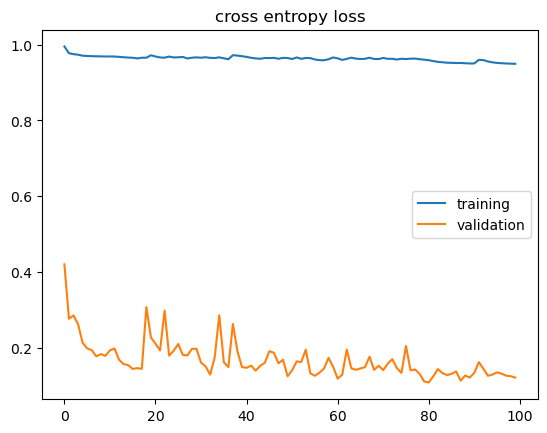

Text(0.5, 1.0, 'accuracy')

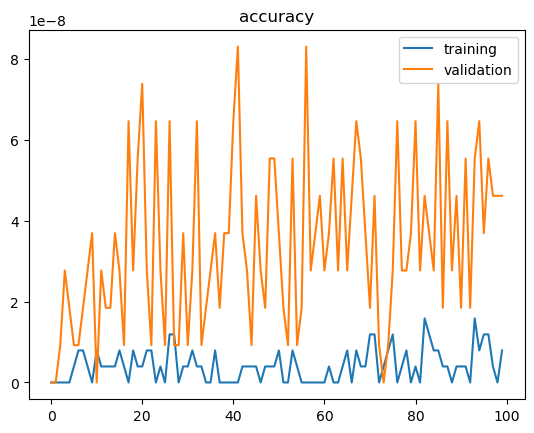

In [8]:
metrics = {
    't_loss': [],
    'v_loss': [],
    't_acc': [],
    'v_acc': []
}
print('****** STARTING TRAINING ******')
for epoch in range(100):
    train_epoch(model, train_dl, val_dl, loss_fn=loss, opt=optimizer, device=device, metrics=metrics)
    print(f"Finished epoch: {epoch}; Training loss: {metrics['t_loss'][-1]}; Validation loss: {metrics['v_loss'][-1]}")

print("Fininshed training")    
print('best validation accuracy', max(metrics['v_acc']).data)

plt.plot(metrics['t_loss'])
plt.plot(metrics['v_loss'])
plt.legend(['training', 'validation'])
plt.title('cross entropy loss')
plt.show()

plt.figure(1)
plt.plot(metrics['t_acc'])
plt.plot(metrics['v_acc'])
plt.legend(['training', 'validation'])
plt.title('accuracy')

In [9]:
torch.save(model, 'lstm_autoencoder')

## Reconstructing Audio Example

In [6]:
model = torch.load('lstm_autoencoder')
model = model.to(device)
model

LSTM_AE(
  (encoder): Encoder(
    (LSTM1): LSTM(16, 128, batch_first=True)
  )
  (decoder): Decoder(
    (LSTM1): LSTM(128, 256, batch_first=True)
    (fc): Linear(in_features=256, out_features=16, bias=True)
  )
)

In [7]:
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[ 0.1427, -0.0925,  0.1123,  ...,  0.1020,  0.1778, -0.0028],
        [ 0.0063,  0.1596,  0.2062,  ...,  0.2037,  0.0263,  0.1418],
        [-0.1881, -0.1286, -0.1440,  ..., -0.0457, -0.0747, -0.0494],
        ...,
        [-0.0179, -0.0835, -0.1272,  ..., -0.0687, -0.1251,  0.1041],
        [ 0.2235,  0.1466,  0.1613,  ...,  0.0651,  0.1491,  0.2034],
        [ 0.1174,  0.0832,  0.0678,  ...,  0.0852,  0.1024,  0.1312]],
       device='cuda:0', requires_grad=True)
Parameter containing:
tensor([[ 0.5350, -0.0111,  0.1049,  ..., -0.2445,  0.2118, -0.1669],
        [-0.2763, -0.2153,  0.1368,  ..., -0.1345, -0.0235, -0.2573],
        [ 0.1154,  0.1742,  0.2340,  ..., -0.0764,  0.3337, -0.1240],
        ...,
        [-0.1878,  0.2288,  0.0978,  ..., -0.0761,  0.0494,  0.0818],
        [ 0.1472,  0.0528, -0.1655,  ...,  0.1875,  0.0955, -0.0199],
        [-0.1011,  0.0283,  0.0191,  ..., -0.0210, -0.1212,  0.2484]],
       device='cuda:0', requires_grad=True)


In [30]:
from utils.codec import CodecTransform

X_example = dataset[1][0]
y_example = dataset[1][1]
print(X_example)

batch_size = 1
n_dim = X_example.shape[0]
length = X_example.shape[1]

# input dimensions for LSTMs: (batch_size, length, n_dim)
X_example = torch.reshape(torch.Tensor(X_example), (batch_size, length, n_dim))
X_example = X_example.to(device)

X_pred = model(X_example)
print(X_pred)

[[0.36132812 0.39453125 0.25097656 ... 0.10058594 0.86621094 0.86621094]
 [0.50390625 0.140625   0.67089844 ... 0.9511719  0.41210938 0.51660156]
 [0.16113281 0.25683594 0.734375   ... 0.49609375 0.3564453  0.99121094]
 ...
 [0.7363281  0.30273438 0.5732422  ... 0.26464844 0.5185547  0.484375  ]
 [0.98828125 0.64746094 0.50878906 ... 0.4404297  0.74609375 0.71777344]
 [0.14941406 0.80859375 0.6513672  ... 0.43066406 0.296875   0.453125  ]]
tensor([[[-0.2522,  0.0245,  0.1188,  ...,  0.2080,  0.2314,  0.1882],
         [ 0.2987,  0.3357,  0.3946,  ...,  0.6207,  0.6205,  0.5918],
         [ 0.4586,  0.4677,  0.5107,  ...,  0.3311,  0.2687,  0.2284],
         ...,
         [ 0.4997,  0.8304,  0.6374,  ...,  0.4964,  0.6204,  0.8361],
         [ 0.6369,  0.8850,  0.5810,  ...,  0.3622,  0.4924,  0.7485],
         [ 0.8924,  0.8974,  0.4125,  ...,  0.3870,  0.5201,  0.6952]]],
       device='cuda:0', grad_fn=<ViewBackward0>)


In [31]:
X_clamp = torch.clamp(X_pred, min=0, max=1023/1024)
X_clamp

tensor([[[0.0000, 0.0245, 0.1188,  ..., 0.2080, 0.2314, 0.1882],
         [0.2987, 0.3357, 0.3946,  ..., 0.6207, 0.6205, 0.5918],
         [0.4586, 0.4677, 0.5107,  ..., 0.3311, 0.2687, 0.2284],
         ...,
         [0.4997, 0.8304, 0.6374,  ..., 0.4964, 0.6204, 0.8361],
         [0.6369, 0.8850, 0.5810,  ..., 0.3622, 0.4924, 0.7485],
         [0.8924, 0.8974, 0.4125,  ..., 0.3870, 0.5201, 0.6952]]],
       device='cuda:0', grad_fn=<ClampBackward1>)

In [23]:
print(X_clamp.max())
print(X_clamp.min())

tensor(0.9990, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0., device='cuda:0', grad_fn=<MinBackward1>)


In [14]:
X_pred.shape

torch.Size([1, 375, 16])

In [9]:
transform = CodecTransform(sample_rate=16000, bandwidth=12)

In [32]:
wav = transform.decode(X_clamp.reshape([1, 16, 375]))

In [25]:
wav

tensor([[ 0.0277,  0.0209,  0.0508,  ..., -0.0615, -0.0423, -0.0258]])

In [33]:
torchaudio.save('test_2.wav', wav, 24000)